# Hackathon 1 - June 2024

In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import openmeteo_requests
import requests_cache
from retry_requests import retry
from sklearn.linear_model import LinearRegression
from dotenv import load_dotenv
import os

In [2]:
# Load the .env file
load_dotenv()

# Get the API key from environment variables
api_key = os.getenv("API_KEY")

## Data gathering

In [3]:
# Boilerplate code for the auto-generated Open-Meteo API
cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

In [4]:
def df_compiler(latitude, longitude, city, data_frame):
    params = {
        "latitude": latitude,
        "longitude":longitude,
        "start_date": "1940-01-01",
        "end_date": "2024-06-26",
        "hourly": ["temperature_2m", "precipitation"], #temperature_2m is the temperature a 2 meter height
        "apikey": api_key
    }

    url = "https://customer-archive-api.open-meteo.com/v1/archive"
    responses = openmeteo.weather_api(url, params=params)

    # Process the location
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()

    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
        end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )}
    hourly_data["temperature_2m"] = hourly_temperature_2m
    hourly_data["precipitation"] = hourly_precipitation
    hourly_data["elevation"] = response.Elevation()
    hourly_data["city"] = city

    hourly_dataframe = pd.DataFrame(data = hourly_data)
    
    df_clean = hourly_dataframe.dropna()
    
    dataset = pd.concat([df_clean, data_frame], ignore_index = True)

    return dataset  

In [5]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)


lugano = {"name": "lugano", "latitude": 46.0101, "longitude": 8.96}
cairo = {"name": "cairo", "latitude": 30.0626, "longitude": 31.2497}
london = {"name": "london", "latitude": 51.5085, "longitude": -0.1257}

df = pd.DataFrame()

citys = [lugano, cairo, london]
for city in citys:
    data_frame = df_compiler(city["latitude"], city["longitude"], city["name"], df )
    
    df = data_frame
df.head()

Coordinates 46.01054382324219°N 8.85714340209961°E
Elevation 282.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 30.052722930908203°N 31.295217514038086°E
Elevation 28.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 51.49384689331055°N -0.16302490234375°E
Elevation 23.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


,date,temperature_2m,precipitation,elevation,city
0,1940-01-01 07:00:00+00:00,-2.151,0.0,23.0,london
1,1940-01-01 08:00:00+00:00,-1.201,0.0,23.0,london
2,1940-01-01 09:00:00+00:00,-0.651,0.0,23.0,london
3,1940-01-01 10:00:00+00:00,3.049,0.0,23.0,london
4,1940-01-01 11:00:00+00:00,3.599,0.0,23.0,london


convert date column to timestamp

In [6]:
df["date"] = pd.to_datetime(df["date"], yearfirst=True)
df.drop(columns=['elevation'], inplace=True)

## Data Visualisation

### Visualize temperatures over the years at different resolutions (monthly, yearly)

In [7]:
df_lugano = df[(df.city == 'lugano')].drop(columns=['city'])
df_cairo = df[(df.city == 'cairo')].drop(columns=['city'])
df_london = df[(df.city == 'london')].drop(columns=['city'])

#display(lugano_df)
#display(cairo_df)
#display(london_df)

lug_monthly_mean = df_lugano.groupby([df_lugano['date'].dt.year, df_lugano['date'].dt.month]).mean(["temperature_2m"])
lug_annual_mean = df_lugano.groupby(df_lugano['date'].dt.year).mean(["temperature_2m"])

cai_monthly_mean = df_cairo.groupby([df_cairo['date'].dt.year, df_cairo['date'].dt.month]).mean(["temperature_2m"])
cai_annual_mean = df_cairo.groupby(df_cairo['date'].dt.year).mean(["temperature_2m"])

lon_monthly_mean = df_london.groupby([df_london['date'].dt.year, df_london['date'].dt.month]).mean(["temperature_2m"])
lon_annual_mean = df_london.groupby(df_london['date'].dt.year).mean(["temperature_2m"])

#### Yearly visualisation

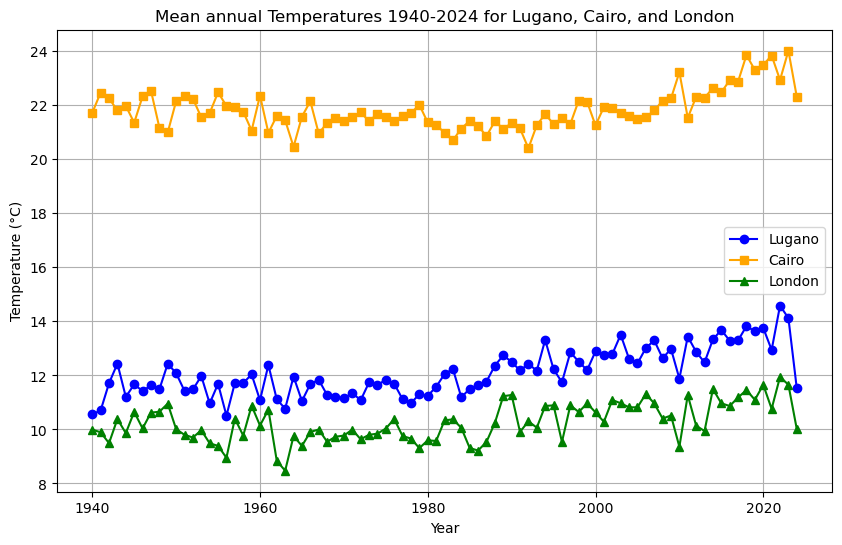

In [8]:
plt.figure(figsize=(10, 6))

plt.plot(lug_annual_mean.index, lug_annual_mean['temperature_2m'], marker='o', linestyle='-', color='b', label='Lugano')
plt.plot(cai_annual_mean.index, cai_annual_mean['temperature_2m'], marker='s', linestyle='-', color='orange', label='Cairo')
plt.plot(lon_annual_mean.index, lon_annual_mean['temperature_2m'], marker='^', linestyle='-', color='g', label='London')

plt.title('Mean annual Temperatures 1940-2024 for Lugano, Cairo, and London')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()

plt.show()

#### Monthly visualisation

Handle Lugano

In [9]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
lug_months_dict = {month: 0 for month in months}

for i in range(1940, 2024):
    ye = lug_monthly_mean['temperature_2m'].loc[i]
    j = 1
    for month in months:
        lug_months_dict[month] += float(ye[j])
        j+=1

for month in months:
    lug_months_dict[month] = lug_months_dict[month]/84

Handle Cairo

In [10]:
cai_months_dict = {month: 0 for month in months}

for i in range(1940, 2024):
    ye = cai_monthly_mean['temperature_2m'].loc[i]
    j = 1
    for month in months:
        cai_months_dict[month] += float(ye[j])
        j+=1

for month in months:
    cai_months_dict[month] = cai_months_dict[month]/84

Handle London 

In [11]:
lon_months_dict = {month: 0 for month in months}

for i in range(1940, 2024):
    ye = lon_monthly_mean['temperature_2m'].loc[i]
    j = 1
    for month in months:
        lon_months_dict[month] += float(ye[j])
        j+=1

for month in months:
    lon_months_dict[month] = lon_months_dict[month]/84

In [12]:
df_month = pd.DataFrame({'lugano': lug_months_dict, 'cairo': cai_months_dict, 'london': lon_months_dict})

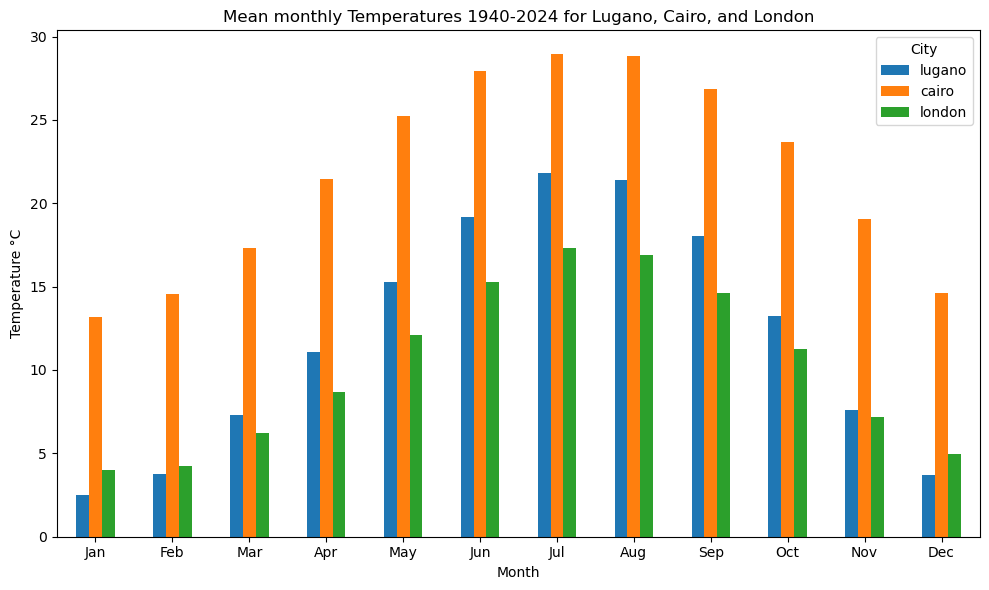

In [13]:
df_month.plot(kind='bar', figsize=(10, 6))

plt.title('Mean monthly Temperatures 1940-2024 for Lugano, Cairo, and London')
plt.xlabel('Month')
plt.ylabel('Temperature °C')
plt.xticks(rotation=360)

plt.legend(title='City')
plt.tight_layout()
plt.show()

### Visualize the typical yearly pattern

In [14]:
# Group by year and month to get the mean temperature
df_lugano['year'] = df_lugano['date'].dt.year
df_lugano['month'] = df_lugano['date'].dt.month
lugano_monthly_temperature_mean = df_lugano.groupby(['year', 'month'])['temperature_2m'].mean().unstack(level=0)

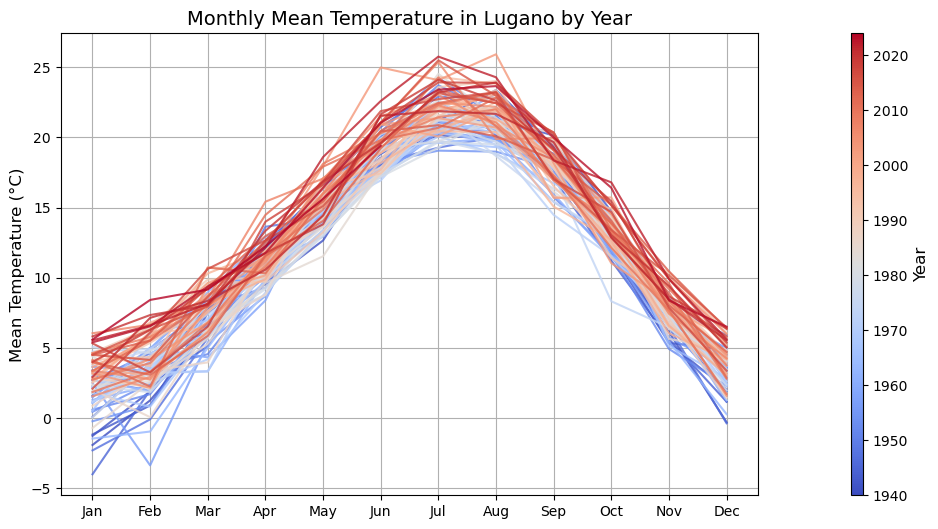

In [15]:
# Define a color map from blue to red
years = lugano_monthly_temperature_mean.columns
year_min = years.min()
year_max = years.max()

# Create a color map that transitions from blue to red
color_map = plt.colormaps['coolwarm']

# Assign colors to each year based on its position in the range
colors = {year: color_map(i / (len(years) - 1)) for i, year in enumerate(sorted(years))}

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

for year in lugano_monthly_temperature_mean.columns:
    ax.plot(
        lugano_monthly_temperature_mean.index,
        lugano_monthly_temperature_mean[year],
        label=str(year),
        color=colors[year],
        alpha=0.8
    )

# Modify x-axis labels for better readability
ax.set_ylabel('Mean Temperature (°C)', fontsize=12)
ax.set_title('Monthly Mean Temperature in Lugano by Year', fontsize=14)

# Set x-axis tick labels as month names
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_labels, fontsize=10)

# Create a gradient colorbar
sm = plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=year_min, vmax=year_max))
sm.set_array([])

# Add the colorbar to the figure
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.1, aspect=40)
cbar.set_label('Year', fontsize=12)
cbar.ax.tick_params(labelsize=10)

ax.grid(True)

# Show the plot
plt.show()


### Analyze precipitations in Lugano

### data manipolation:

In [16]:
# Group by year and month to get the mean temperature
df_lugano['year'] = df_lugano['date'].dt.year
df_lugano['month'] = df_lugano['date'].dt.month
lugano_monthly_precepitation_mean = df_lugano.groupby(['year', 'month'])['precipitation'].mean().unstack(level=0)

# Calculate the general mean for precipitation
general_mean_precipitation = df_lugano.groupby('month')['precipitation'].mean()

### 2024 and 2022 over all other year precipiation

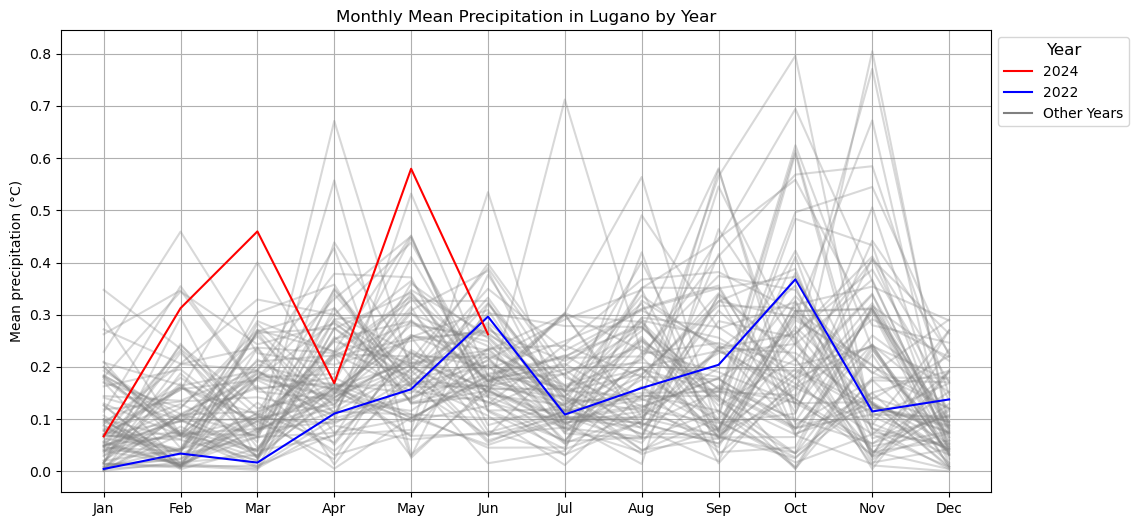

In [17]:
from matplotlib.lines import Line2D

# Your plot code
plt.figure(figsize=(12, 6))

for year in lugano_monthly_precepitation_mean.columns:
    if year == 2024:
        plt.plot(lugano_monthly_precepitation_mean.index, lugano_monthly_precepitation_mean[year], label=str(year), color="red")
    elif year == 2022:
        plt.plot(lugano_monthly_precepitation_mean.index, lugano_monthly_precepitation_mean[year], label=str(year), color="blue")
    else:
        plt.plot(lugano_monthly_precepitation_mean.index, lugano_monthly_precepitation_mean[year], color="grey", alpha=0.3)

plt.ylabel('Mean precipitation (°C)')
plt.title('Monthly Mean Precipitation in Lugano by Year')
plt.grid(True)

# Set x-axis tick labels as month names
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(ticks=range(1, 13), labels=month_labels)

# Custom legend
legend_elements = [
    Line2D([0], [0], color='red', label='2024'),
    Line2D([0], [0], color='blue', label='2022'),
    Line2D([0], [0], color='grey', label='Other Years')
]

#plt.legend(handles=legend_elements, title='Year', loc='vertical', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.legend(handles=legend_elements, title='Year',title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize=10)




plt.show()


### Chart with 2024, 2022 and mean of the last 84 years

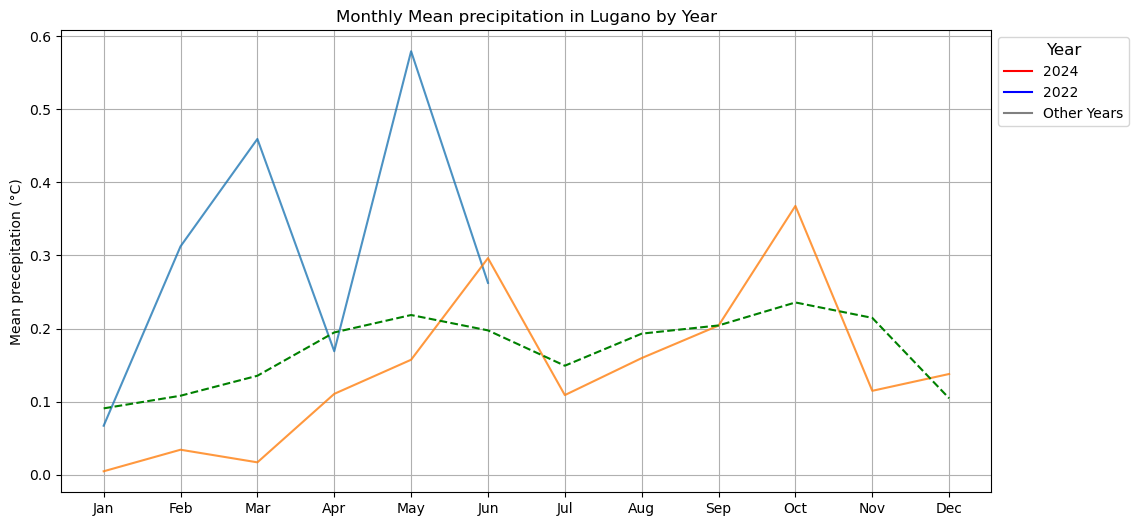

In [18]:
plt.figure(figsize=(12, 6))

plt.plot(lugano_monthly_precepitation_mean.index, lugano_monthly_precepitation_mean[2024], label=str(year), alpha = 0.8)
plt.plot(lugano_monthly_precepitation_mean.index, lugano_monthly_precepitation_mean[2022], label=str(year), alpha = 0.8)
plt.plot(general_mean_precipitation.index, general_mean_precipitation, label='General Mean Precipitation', linestyle='--', color='green')



plt.ylabel('Mean precepitation (°C)')
plt.title('Monthly Mean precipitation in Lugano by Year')
plt.legend(title='Year', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=10)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(ticks=range(1, 13), labels=month_labels)

plt.grid(True)
plt.legend(handles=legend_elements, title='Year',title_fontsize=12, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize=10)

plt.show()

#### how exceptional has been 2024 so far?

Precipitation in 2024 is well above average, there have been other years in the past with such high precipitation.

#### How exceptional was 2022?

At the beginning of 2022, precipitation was below average, then there were higher-than-average precipitation peaks in June and October.

## Modelling

### Linear regression temperature vs year

first we have to divide the data of each city in three different dataframes   
based on the regression that we want do

In [19]:
df_lugano = df[(df.city == 'lugano')].drop(columns=['city'])
df_cairo = df[(df.city == 'cairo')].drop(columns=['city'])
df_london = df[(df.city == 'london')].drop(columns=['city'])

cities = [df_lugano, df_cairo, df_london]

In [20]:
# dataframes for the linear regression
lr_df = df.groupby(df.date.dt.year)[['temperature_2m']].mean()
lr_df_lugano = df_lugano.groupby(df_lugano.date.dt.year)[['temperature_2m']].mean()
lr_df_cairo = df_cairo.groupby(df_cairo.date.dt.year)[['temperature_2m']].mean()
lr_df_london = df_london.groupby(df_london.date.dt.year)[['temperature_2m']].mean()

lr_dfs = [lr_df, lr_df_lugano, lr_df_cairo, lr_df_london]

#### Function

In [21]:
def df_for_linear_regression(dataframe, start, end):
    dataframe = dataframe.reset_index()
    
    # create the model
    x = dataframe['date']
    y = dataframe['temperature_2m']

    p = np.polyfit(x, y, 1) # the last is the degree of freedom
    a1, a0 = p
    
    # now create the global dataframe with the dates that we don't know and that we know
    start_date = start
    end_date = end
    
    # creates a temporary dataframe with also the data that we don't know
    x_to_pred = np.arange(start_date, end_date, 1)
    y_pred = np.polyval(p, x_to_pred)
    tmp = pd.DataFrame({"date": x_to_pred, "temperature_2m_predicted": y_pred})

    # right join the two dataframes
    df_result = tmp.merge(dataframe, on=["date"], how="outer")
    
    return df_result

In [22]:
def plot_linear_regression(dataframe, city):
    x = dataframe['date']
    y = dataframe['temperature_2m']
    y_hat = dataframe['temperature_2m_predicted']
    
    fig = px.scatter(dataframe, x = x, y = y, title=f'Temperature prediction for {city}')
    fig.add_trace(go.Scatter(x=[x.min(), x.max()], y=[y_hat.min(), y_hat.max()],
                             mode = 'lines', line=dict(color='red', width=2),
                             name=f'Regression line of {city}'))
    return fig

In [23]:
data_all = df_for_linear_regression(lr_df, 1940, 2051)
data_lugano = df_for_linear_regression(lr_df_lugano, 1940, 2051)
data_cairo = df_for_linear_regression(lr_df_cairo, 1940, 2051)
data_london = df_for_linear_regression(lr_df_london, 1940, 2051)

plot_lr_all = plot_linear_regression(data_all, 'all cities')
plot_lr_lugano = plot_linear_regression(data_lugano, 'Lugano')
plot_lr_cairo = plot_linear_regression(data_cairo, 'Cairo')
plot_lr_london = plot_linear_regression(data_london, 'London')

#### Visualisation

In [24]:
display('ALL CITIES', data_all)
plot_lr_all.show()

'ALL CITIES'

,date,temperature_2m_predicted,temperature_2m
0,1940,13.985154,14.089478
1,1941,14.002958,14.355490
2,1942,14.020762,14.486165
3,1943,14.038566,14.876647
4,1944,14.056370,14.347838
...,...,...,...
106,2046,15.872389,NaN
107,2047,15.890193,NaN
108,2048,15.907997,NaN
109,2049,15.925801,NaN


In [25]:
display('Lugano', data_lugano)
plot_lr_lugano.show()

'Lugano'

,date,temperature_2m_predicted,temperature_2m
0,1940,10.978728,10.555459
1,1941,11.005582,10.701631
2,1942,11.032435,11.710346
3,1943,11.059288,12.436607
4,1944,11.086141,11.205368
...,...,...,...
106,2046,13.825159,NaN
107,2047,13.852012,NaN
108,2048,13.878865,NaN
109,2049,13.905718,NaN


In [26]:
display('Cairo', data_cairo)
plot_lr_cairo.show()

'Cairo'

,date,temperature_2m_predicted,temperature_2m
0,1940,21.363984,21.718615
1,1941,21.375166,22.471790
2,1942,21.386348,22.256868
3,1943,21.397529,21.806921
4,1944,21.408711,21.976625
...,...,...,...
106,2046,22.549238,NaN
107,2047,22.560419,NaN
108,2048,22.571601,NaN
109,2049,22.582783,NaN


In [27]:
display('London', data_london)
plot_lr_london.show()

'London'

,date,temperature_2m_predicted,temperature_2m
0,1940,9.612750,9.994357
1,1941,9.628127,9.893053
2,1942,9.643505,9.491277
3,1943,9.658882,10.386415
4,1944,9.674260,9.861523
...,...,...,...
106,2046,11.242770,NaN
107,2047,11.258147,NaN
108,2048,11.273525,NaN
109,2049,11.288902,NaN


### Prediction until 2070

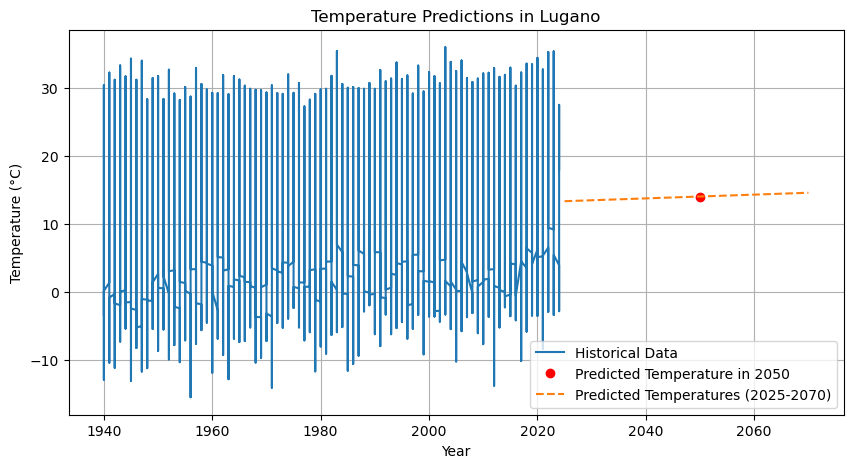

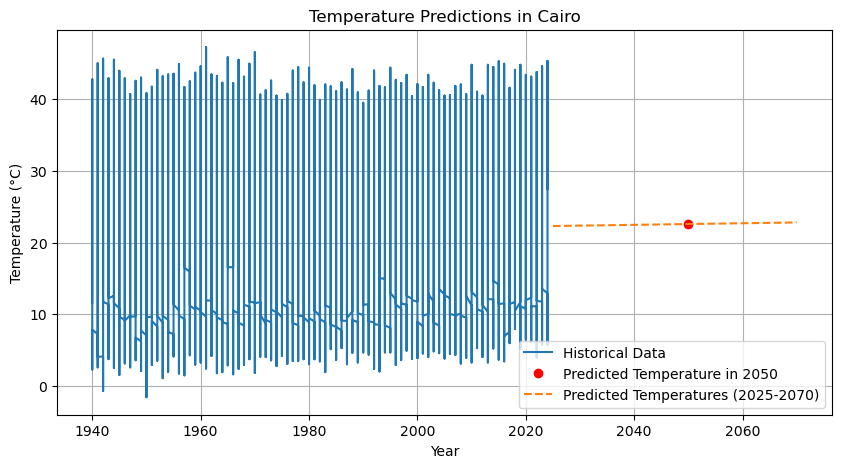

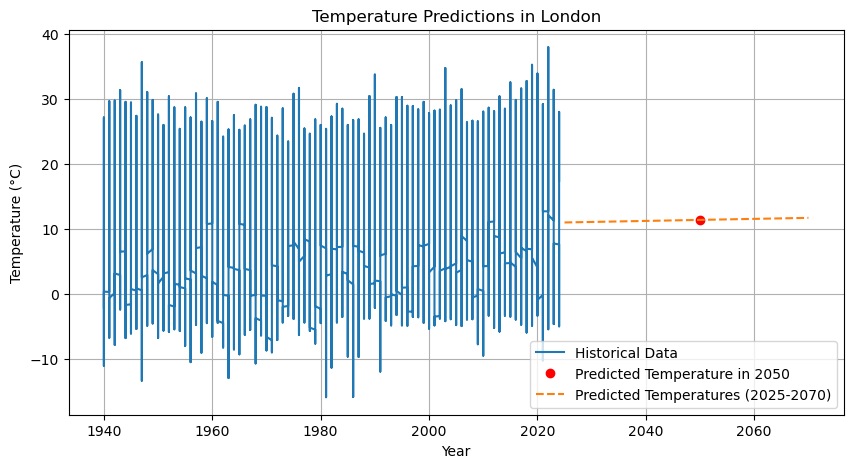

In [28]:
def linear_regression_model(df, city_name):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])  # Convert 'date' column to datetime if needed
    df['year'] = df['date'].dt.year  # Extract year from 'date' column
    
    X = np.array(df['year']).reshape(-1, 1)
    y = df['temperature_2m']
    
    model = LinearRegression()
    model.fit(X, y)

    year_2050 = np.array([2050]).reshape(-1, 1)
    temperature_2050 = model.predict(year_2050)
    
    future_years = np.array(range(2025, 2071)).reshape(-1, 1)
    predictions = model.predict(future_years)
    
    plt.figure(figsize=(10, 5))
    plt.plot(df['year'], df['temperature_2m'], label='Historical Data')
    plt.plot(year_2050, temperature_2050, 'ro', label='Predicted Temperature in 2050')
    plt.plot(future_years, predictions, label='Predicted Temperatures (2025-2070)', linestyle='--')
    plt.xlabel('Year')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Temperature Predictions in {city_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

linear_regression_model(df_lugano, 'Lugano')
linear_regression_model(df_cairo, 'Cairo')
linear_regression_model(df_london, 'London')

### Comparison between my prediction and open-meteo prediction

In [29]:
def predicted_by_site(city):
    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    #url = "https://climate-api.open-meteo.com/v1/climate"
    url = "https://customer-climate-api.open-meteo.com/v1/climate"
    params = {
        "latitude": city['latitude'],
        "longitude": city['longitude'],
        "start_date": "1950-01-01",
        "end_date": "2050-12-31",
        "models": ["CMCC_CM2_VHR4", "FGOALS_f3_H", "HiRAM_SIT_HR", "MRI_AGCM3_2_S", "EC_Earth3P_HR", "MPI_ESM1_2_XR", "NICAM16_8S"],
        "daily": "temperature_2m_mean",
        "apikey": "5ftjs2VK6XVIpyYM" # commercial API key, with more tokens available than the free API key
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    #print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    #print(f"Elevation {response.Elevation()} m asl")
    #print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    #print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

    # Process daily data. The order of variables needs to be the same as requested.
    daily = response.Daily()
    daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()

    daily_data = {"date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
        end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = daily.Interval()),
        inclusive = "left"
    )}
    daily_data["temperature_2m_mean"] = daily_temperature_2m_mean

    daily_dataframe = pd.DataFrame(data = daily_data)
    daily_dataframe = daily_dataframe.groupby(daily_dataframe.date.dt.year)[['temperature_2m_mean']].mean()
    return daily_dataframe

In [30]:
yearly_data_lugano = predicted_by_site(lugano).reset_index()
yearly_data_cairo = predicted_by_site(cairo).reset_index()
yearly_data_london = predicted_by_site(london).reset_index()

data_lugano = data_lugano.merge(yearly_data_lugano, on=["date"], how="outer")
data_lugano.rename(columns={'temperature_2m_mean': 'temperature_2m_predicted_by_site'}, inplace=True)
data_cairo = data_cairo.merge(yearly_data_cairo, on=["date"], how="outer")
data_cairo.rename(columns={'temperature_2m_mean': 'temperature_2m_predicted_by_site'}, inplace=True)
data_london = data_london.merge(yearly_data_london, on=["date"], how="outer")
data_london.rename(columns={'temperature_2m_mean': 'temperature_2m_predicted_by_site'}, inplace=True)

In [31]:
display(data_all, data_lugano, data_cairo, data_london)

,date,temperature_2m_predicted,temperature_2m
0,1940,13.985154,14.089478
1,1941,14.002958,14.355490
2,1942,14.020762,14.486165
3,1943,14.038566,14.876647
4,1944,14.056370,14.347838
...,...,...,...
106,2046,15.872389,NaN
107,2047,15.890193,NaN
108,2048,15.907997,NaN
109,2049,15.925801,NaN


,date,temperature_2m_predicted,temperature_2m,temperature_2m_predicted_by_site
0,1940,10.978728,10.555459,NaN
1,1941,11.005582,10.701631,NaN
2,1942,11.032435,11.710346,NaN
3,1943,11.059288,12.436607,NaN
4,1944,11.086141,11.205368,NaN
...,...,...,...,...
106,2046,13.825159,NaN,14.008055
107,2047,13.852012,NaN,14.436139
108,2048,13.878865,NaN,16.105919
109,2049,13.905718,NaN,14.666975


,date,temperature_2m_predicted,temperature_2m,temperature_2m_predicted_by_site
0,1940,21.363984,21.718615,NaN
1,1941,21.375166,22.471790,NaN
2,1942,21.386348,22.256868,NaN
3,1943,21.397529,21.806921,NaN
4,1944,21.408711,21.976625,NaN
...,...,...,...,...
106,2046,22.549238,NaN,23.192188
107,2047,22.560419,NaN,23.215189
108,2048,22.571601,NaN,23.814901
109,2049,22.582783,NaN,24.059025


,date,temperature_2m_predicted,temperature_2m,temperature_2m_predicted_by_site
0,1940,9.612750,9.994357,NaN
1,1941,9.628127,9.893053,NaN
2,1942,9.643505,9.491277,NaN
3,1943,9.658882,10.386415,NaN
4,1944,9.674260,9.861523,NaN
...,...,...,...,...
106,2046,11.242770,NaN,11.911225
107,2047,11.258147,NaN,12.252460
108,2048,11.273525,NaN,12.733565
109,2049,11.288902,NaN,11.591511
